In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# import my modules for reading dataframes from folder /modules

import sys

sys.path.insert(0, 'modules/')
    
from tumor_data_processor import * 
from tumor_data_processor_2 import * 
from lengths_data_processor import *

In [3]:
data = pd.read_csv('datasets/P6.Inform/I062.022.WGS.Tumor_events.txt', sep='\t', comment='#')

data

,Chromosome Region,Event,Length,Cytoband,% of CNV Overlap,Probe Median,% Heterozygous,Probes,Count of Gene Symbols
0,"chr1:862,439-1,313,714",CN Gain,451276,p36.33,100.000000,0.254980,NaN,15,35
1,"chr1:2,323,340-2,500,322",CN Gain,176983,p36.32,98.491937,0.372007,NaN,6,8
2,"chr1:9,840,751-10,297,200",CN Loss,456450,p36.22,4.657695,-0.247301,NaN,14,8
3,"chr1:28,313,363-29,454,028",CN Loss,1140666,p35.3,5.721575,-0.252082,NaN,34,25
4,"chr1:32,265,271-32,656,728",CN Loss,391458,p35.2 - p35.1,6.300564,-0.241056,NaN,12,7
...,...,...,...,...,...,...,...,...,...
374,"chrX:153,411,122-153,945,270",High Copy Gain,534149,q28,100.000000,0.746978,NaN,16,37
375,"chrX:153,945,270-154,722,592",CN Gain,777323,q28,100.000000,0.346073,NaN,24,47
376,"chrX:154,722,592-155,270,560",CN Loss,547969,q28,89.647206,-0.355816,NaN,15,8
377,"chrY:3,095,792-7,022,409",CN Loss,3926618,p11.2,10.072309,-0.745243,NaN,12,19


In [4]:
test_data = process_tumor_data(data)

test_data

,Chromosome,Copy Number,Length,Start,End
0,1,3,451276,862439,1313714
1,1,3,176983,2323340,2500322
2,1,1,456450,9840751,10297200
3,1,1,1140666,28313363,29454028
4,1,1,391458,32265271,32656728
...,...,...,...,...,...
347,22,1,539800,28754409,29294208
348,22,1,423408,31741627,32165034
349,22,3,459942,37448717,37908658
350,22,1,1851736,40438665,42290400


In [5]:
lengths = pd.read_csv('datasets/hs37d5.fa.fai', sep='\t', header=None)

In [6]:
lengths = process_lengths_data(lengths)

# data is in good format
lengths

,Length
Chromosome,
1,249250621
2,243199373
3,198022430
4,191154276
5,180915260
6,171115067
7,159138663
8,146364022
9,141213431


In [7]:
# set copy number values from events to current bin
def update_bin_value(_bin, bin_start, bin_end, event_start, event_end, event_cn):
    
    # if event starts before bin start and ends somewhere after or at bin start
    if event_start <= bin_start and event_end >= bin_start:
        update_start = 0
        
        # if event ends after bin end
        if event_end >= bin_end:
            update_end = bin_end
            
        # if event ends somewhere in bin
        else:
            update_end = event_end - bin_start
            
        _bin[update_start:update_end+1] = event_cn
        
    # if event starts somewhere in bin and ends after bin start
    elif event_start <= bin_end and event_end >= bin_start:
        update_start = event_start - bin_start
        
        # if event ends after bin end
        if event_end >= bin_end:
            update_end = bin_end
            
         # if event ends somewhere inside bin
        else:
            update_end = event_end - bin_start
            
        _bin[update_start:update_end+1] = event_cn
        
    

# split one chromosome to bigger units - bins, default bin size = 30000 bases
def split_chromosome_to_bins(chromosome_data, chromosome_len, bin_len=30000):
    bins = []
    
    # iteration over chromosome length by steps of size bin length
    for base in range(1, chromosome_len+1, bin_len):
        if chromosome_len - base < bin_len:  # last short bin
            curr_bin_len = chromosome_len - base
        else:
            curr_bin_len = bin_len
            
        # initialize bin values
        _bin = np.full((curr_bin_len), 2)
        
        bin_start = base
        bin_end = base + bin_len - 1
        
        # iterate through cnv events
        for index, row in chromosome_data.iterrows():
            event_start = row['Start']
            event_end = row['End']
            event_copy_number = row['Copy Number']
            
            update_bin_value(_bin, bin_start, bin_end, event_start, event_end, event_copy_number)
        
        # counting average of bases cn values in current bin
        bin_avg = np.average(_bin)
        bins.append(bin_avg)
    
    return bins

In [8]:
def plot_bins(bins):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(bins, color='k')
    ax.set_ylim([-0.5, 4.5])
    ax.set_xlim([0, len(bins)])

    ax.axhline(y=2, color='gray', dashes=(5, 5))

In [9]:
def scatter_bins(bins):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.scatter(range(len(bins)), bins, c='k', s=8)
   
    ax.set_ylim([-0.5, 4.5])
    ax.set_xlim([0, len(bins)])

    ax.axhline(y=2, color='gray', dashes=(5, 5))

In [10]:
# list holding names of chromosomes (not sex chromosomes)
chromosome_names = [str(_chr) for _chr in range(1, 23)]

chromosome_names

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22']

In [11]:
# split all chromosomes of one genome to bins (not X and Y )
def split_genome_to_bins(data, bin_len=30000):
    
    # bins will be stored in 2-d list (every sublist represents bins of one chromosome)
    bins = []
    
    # iterate through chromosome names except X and Y
    for _chr in chromosome_names:
        
        # filter events of current chromosome
        chr_data = data[data['Chromosome'] == _chr]
        
        # length of current chromosome
        chr_len = lengths.loc[[_chr]]['Length'].item()
        
        # split current chromosome to bins
        chr_bins = split_chromosome_to_bins(chr_data, chr_len, bin_len=bin_len)
        
        # add current chromosome bins to list
        bins.append(chr_bins)
        
    return bins

In [12]:
# flatten 2-d array
def flatten_bins(bins):
    return [value for _chr in bins for value in _chr]

In [13]:
# count areas that bins with deviated CN creates between its records and axis - y = 2
def count_chromosome_area(chromosome_bins):
    area = 0
    for _bin in chromosome_bins:
        area += abs(_bin - 2)
        
    return area

In [14]:
# count absolute areas of all chromosomes of genome
def count_genome_areas(bins):
    
    # areas will be stored in 1-d list (every item represents area of one chromosome)
    areas = []
    for _chr in bins:
        chr_area = count_chromosome_area(_chr)
        areas.append(chr_area)
        
    return areas

In [15]:
def visualize_areas_bar(areas, ylim=None):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(chromosome_names, areas)
    ax.set_ylim(ylim)

In [16]:
# count relative areas of chromosomes against their lengths
def count_relative_areas(areas, bins):
    relative_areas = []
    for idx, area in enumerate(areas):
        
        # length (in bins) of current chromosome
        chr_len = len(bins[idx])
        
        # count relative area
        relative_area = area / chr_len
        relative_areas.append(relative_area)
        
    return relative_areas

In [17]:
# count rate of bases in genome with deviated CN values
def count_cnv_rate(data):
    
    # count length of all chromosomes in genome
    genome_length = lengths['Length'].sum(axis=0)
    
    # count sum of events lengths
    cnv_events_length = data['Length'].sum(axis=0)
    
    # return CNV rate of genome
    return cnv_events_length / genome_length

In [18]:
from collections import Counter

In [19]:
def intersection(s1, s2) : 
  
    # Find the intersection of the two sets  
    intersect = list((Counter(s1) & Counter(s2)).elements())
#     s1_np = np.array(s1)
#     s2_np = np.array(s2)

#     intersect = s2_np[np.isclose(s1_np,s2_np)]
#     print(len(intersect))
    return intersect


def jaccard(bins1, bins2):
    # Sizes of both the sets  
    size1 = len(bins1)
    size2 = len(bins2)  
  
    # Get the intersection set  
    intersect = intersection(bins1, bins2)
  
    # Size of the intersection set  
    size_in = len(intersect)
  
    # Calculate the Jaccard index  
    # using the formula  
    jaccard_in = size_in  / (size1 + size2 - size_in)  
  
    # Return the Jaccard index  
    return jaccard_in

In [20]:
import os

In [21]:
def read_files_test(directory_path):
    for filename in  os.listdir(directory_path):
        if filename.endswith(".txt"):
            relative_path = os.path.join(directory_path, filename)
            print(relative_path)

In [22]:
read_files_test('datasets/P6.Inform')

datasets/P6.Inform\I062.007.WGS.Pre_events.txt
datasets/P6.Inform\I062.007.WGS.Tumor_events.txt
datasets/P6.Inform\I062.015.WGS.Tumor_events.txt
datasets/P6.Inform\I062.022.WGS.Tumor_events.txt
datasets/P6.Inform\I062.033.WGS.Tumor_events.txt


In [23]:
# read data of all tumors
def read_tumors(directory_path):
    tumors = []
    for filename in os.listdir(directory_path)[:-1]:
         if filename.endswith(".txt"):
            relative_path = os.path.join(directory_path, filename)
            data = pd.read_csv(relative_path, sep='\t', comment='#')
            data = process_tumor_data(data)
            
            tumors.append(data)
    
    filename = os.listdir(directory_path)[-1]
    relative_path = os.path.join(directory_path, filename)
    data = pd.read_csv(relative_path, sep='\t', header=None)
    data = process_tumor_data_2(data)
    tumors.append(data)
    
    return tumors

In [24]:
tumors = read_tumors('datasets\P6.Inform')

tumors

[    Chromosome  Copy Number   Length     Start       End
 0            1            1   745088   2789792   3534879
 1            1            3  1235765   9453839  10689603
 2            1            3  1305427  15793573  17098999
 3            1            3  1505877  28045550  29551426
 4            1            3   793193  32425081  33218273
 ..         ...          ...      ...       ...       ...
 98          21            3   361580  10265852  10627431
 100         22            1   235248  18636876  18872123
 101         22            3   369487  21665277  22034763
 102         22            3   426659  31774440  32201098
 103         22            1  1147816  48918773  50066588
 
 [98 rows x 5 columns],
     Chromosome  Copy Number    Length      Start        End
 1            1            3   2482505   85008845   87491349
 2            1            3   7563961  113613048  121177008
 4            1            3   1866103  144014595  145880697
 5            1            3   268

In [25]:
# split all tumors to bins
def split_tumors_to_bins(tumors, bin_len=30000):
    tumors_bins = []
    for tumor in tumors:
        tumor_bins = split_genome_to_bins(tumor, bin_len=bin_len)
        tumors_bins.append(tumor_bins)
    
    return tumors_bins

In [26]:
tumors_bins = split_tumors_to_bins(tumors, bin_len=50000)

In [27]:
# flatten all tumors bins
def flatten_tumors_bins(tumors_bins):
    flattened_tumors_bins = []
    for tumor_bins in tumors_bins:
        flattened_bins = flatten_bins(tumor_bins)
        flattened_tumors_bins.append(flattened_bins)
        
    return flattened_tumors_bins

In [28]:
flattened_tumors_bins = flatten_tumors_bins(tumors_bins)

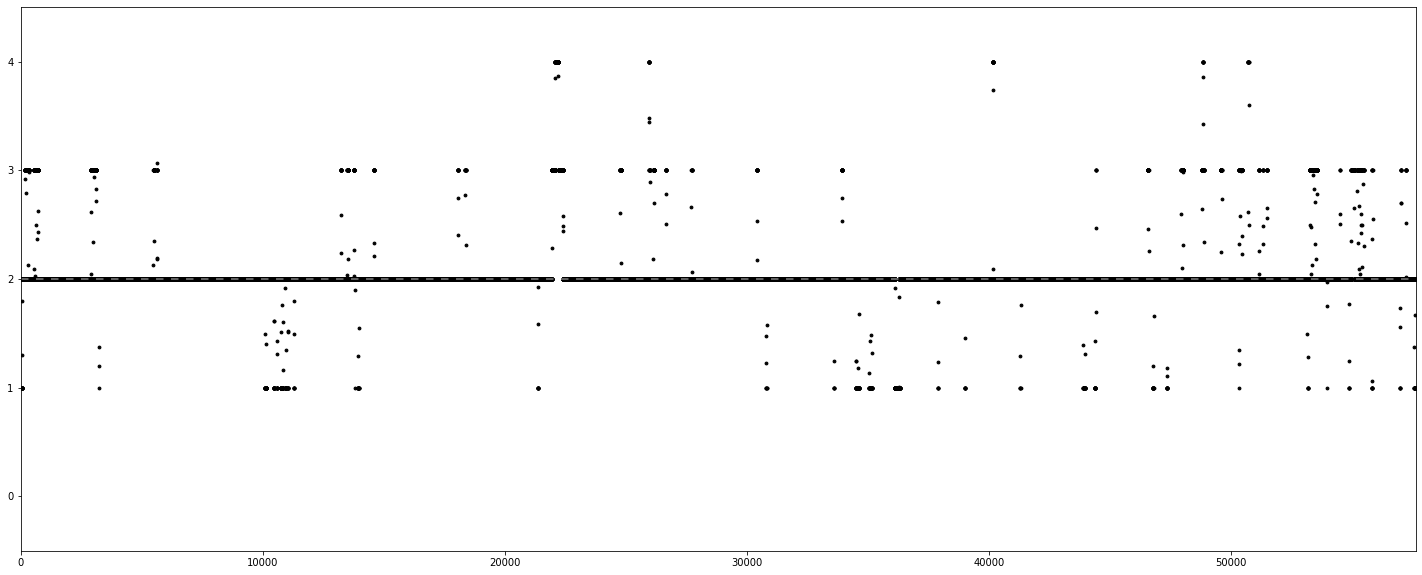

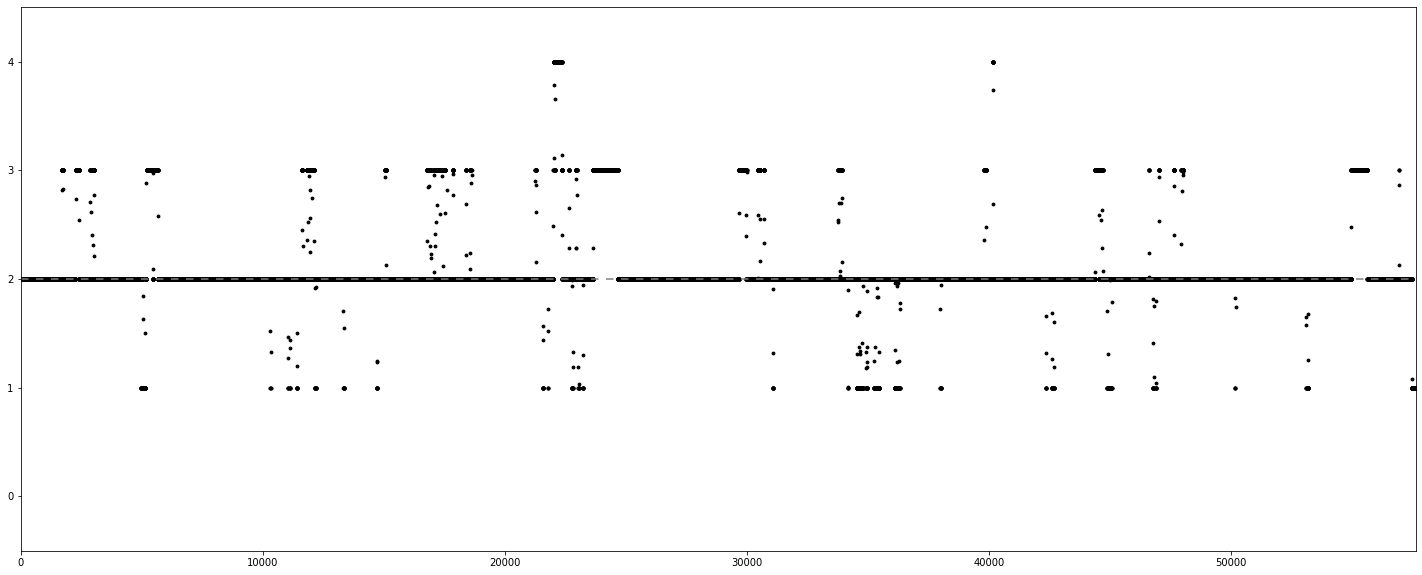

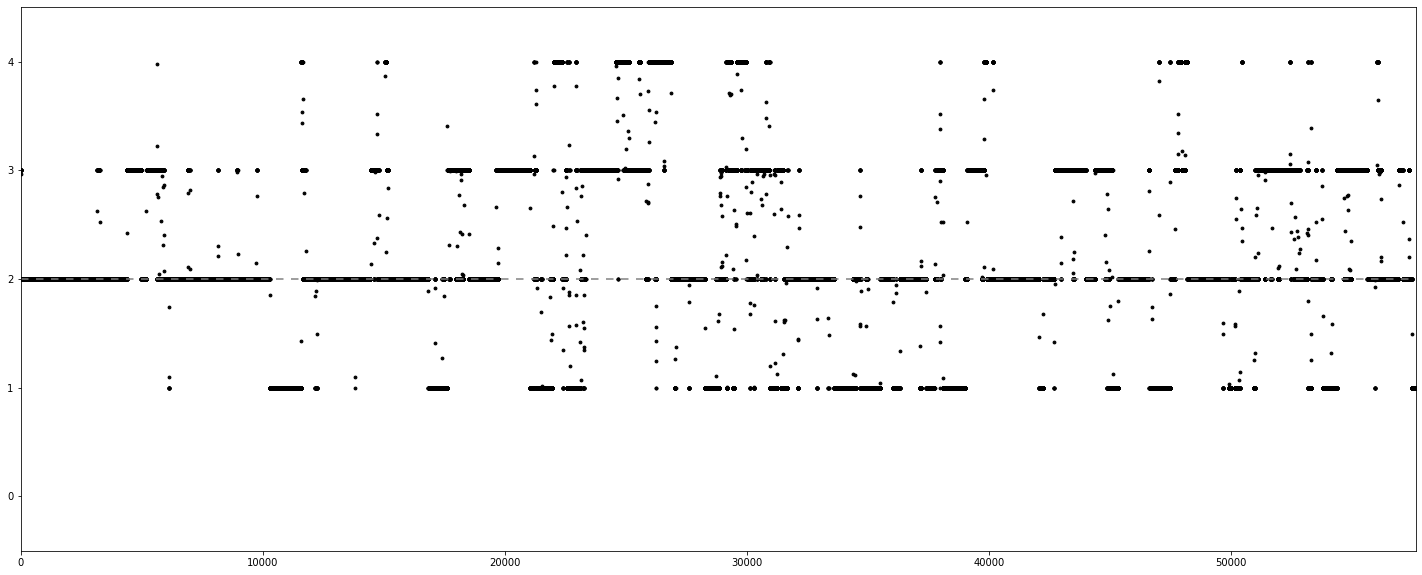

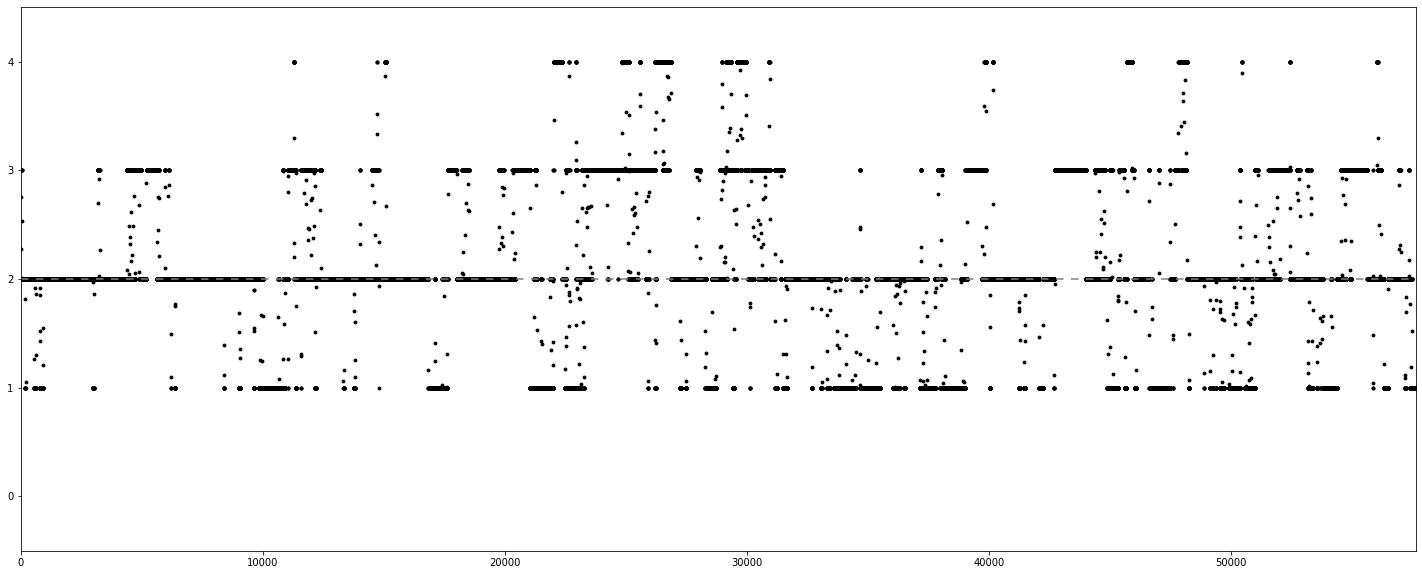

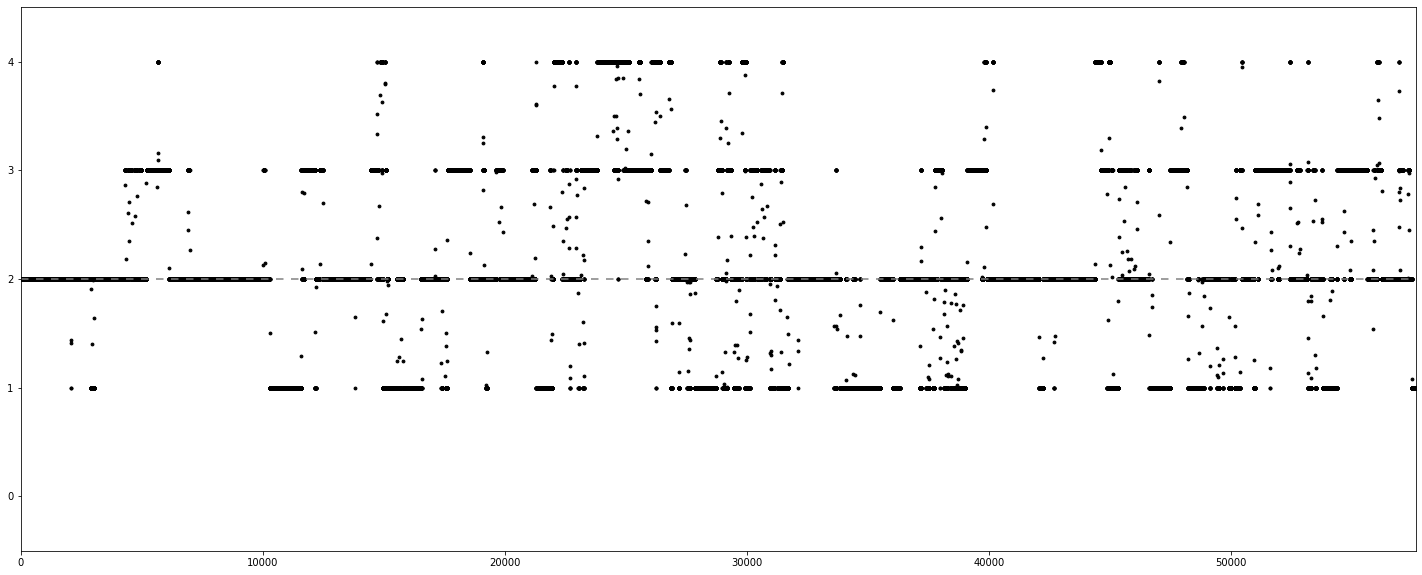

In [29]:
# scatter plot for every tumors genome
for flattened_bins in flattened_tumors_bins:
    scatter_bins(flattened_bins)

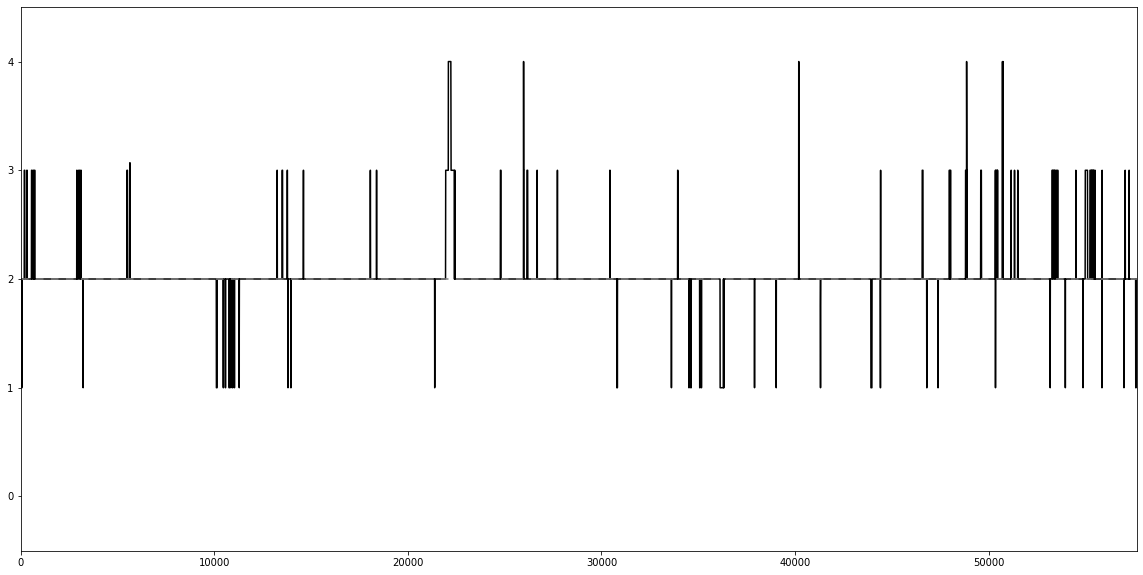

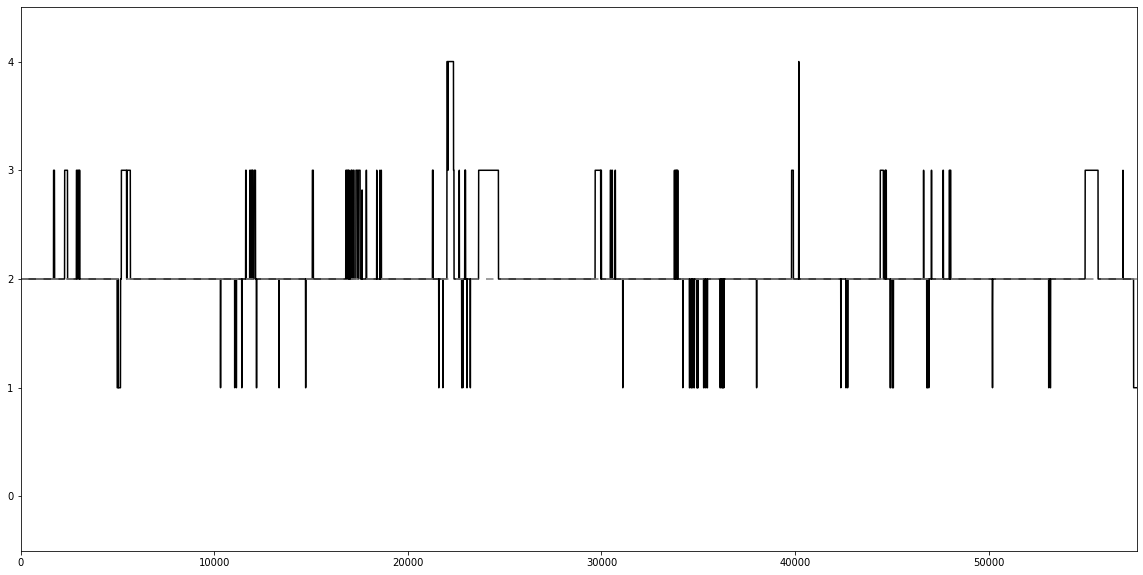

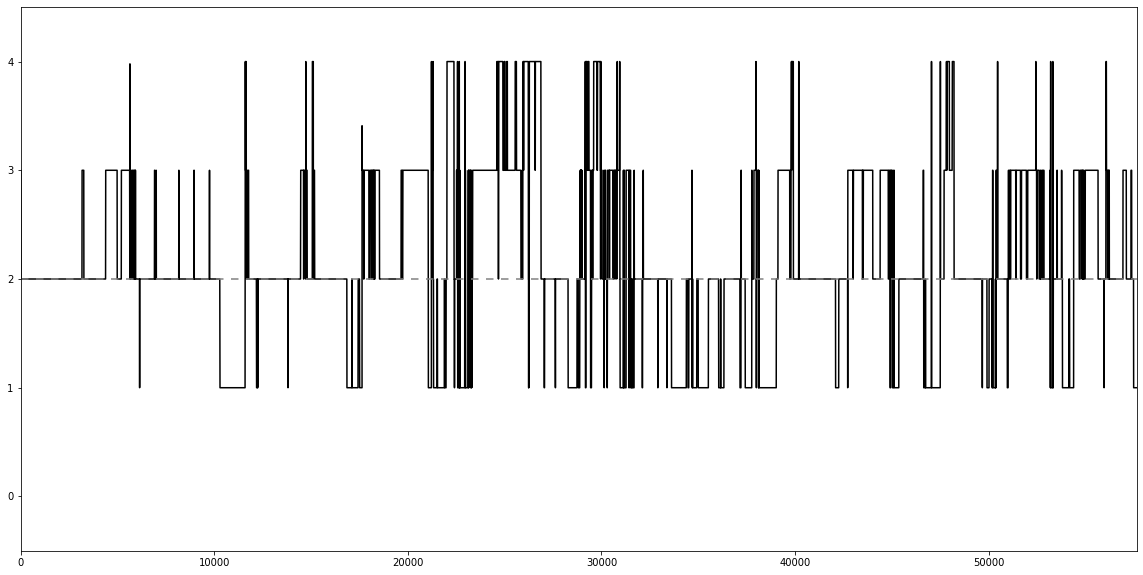

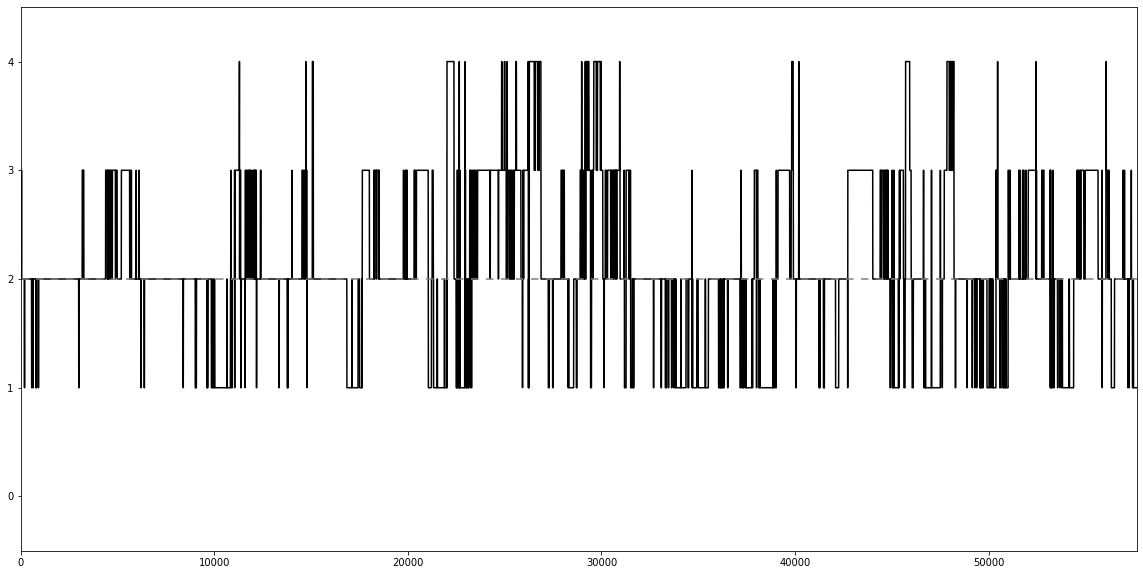

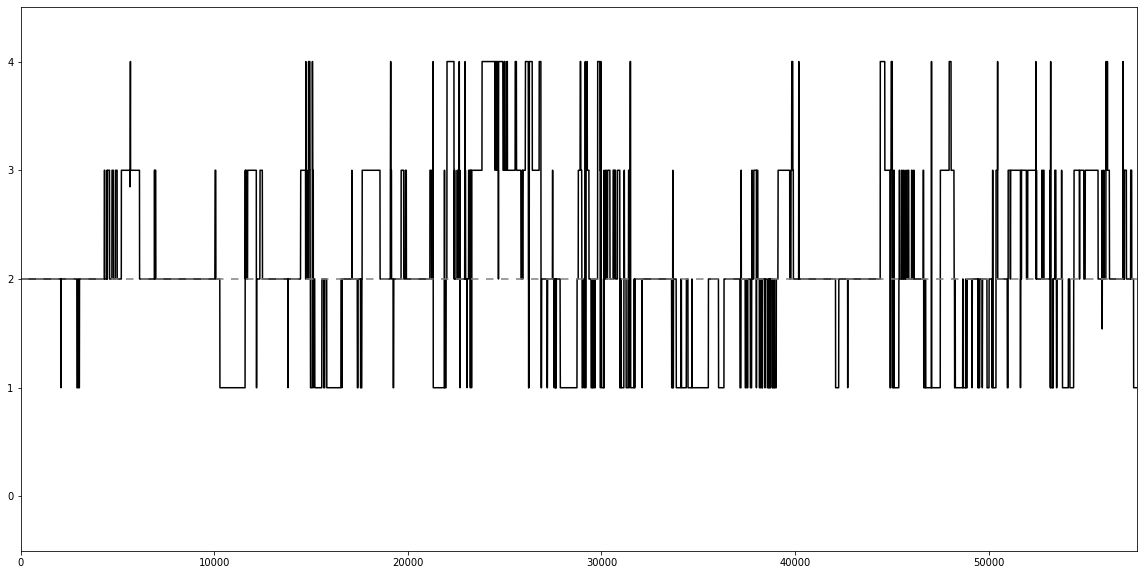

In [30]:
# plot bins of every tumors genome
for flattened_bins in flattened_tumors_bins:
    plot_bins(flattened_bins)

In [31]:
# count areas of every chromosome of every tumors genome
def count_tumors_areas(tumors_bins):
    tumors_areas = []
    for tumor_bins in tumors_bins:
        tumor_areas = count_genome_areas(tumor_bins)
        tumors_areas.append(tumor_areas)
        
    return tumors_areas

In [32]:
tumors_areas = count_tumors_areas(tumors_bins)

tumors_areas

[[235.67079999999999,
  39.91402,
  188.8545,
  28.79142,
  22.23228,
  600.99946,
  127.46638,
  14.70334,
  11.469059999999999,
  278.78832,
  11.51736,
  34.78604,
  56.2936,
  18.33664,
  113.56284000000002,
  97.26518,
  146.00324000000003,
  6.22722,
  165.21159999999998,
  267.34034,
  13.84886,
  43.584199999999996],
 [310.95036000000005,
  613.54762,
  248.11316,
  428.59558,
  49.655199999999994,
  1824.4084999999998,
  0.0,
  387.76410000000004,
  9.77096,
  351.56450000000007,
  11.330960000000001,
  121.27098,
  30.281019999999998,
  297.39734,
  113.1573,
  0.0,
  4.430000000000001,
  23.84268,
  0.0,
  668.4777799999999,
  0.0,
  159.9124],
 [701.54138,
  640.02226,
  1522.1838200000002,
  1183.35648,
  2298.52164,
  3539.6499000000003,
  3325.69168,
  2396.73032,
  906.6035199999999,
  1833.5129600000002,
  1554.4282000000003,
  855.3901399999999,
  1422.2174400000001,
  911.7664600000002,
  1658.9142000000002,
  118.87898,
  841.4765199999999,
  978.5724799999999,
  70

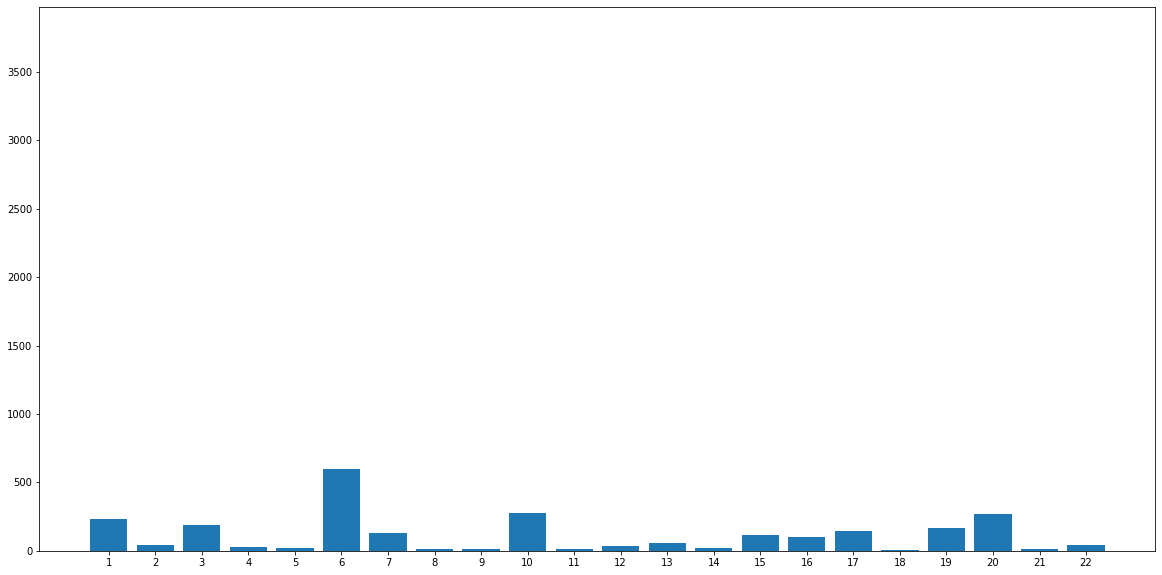

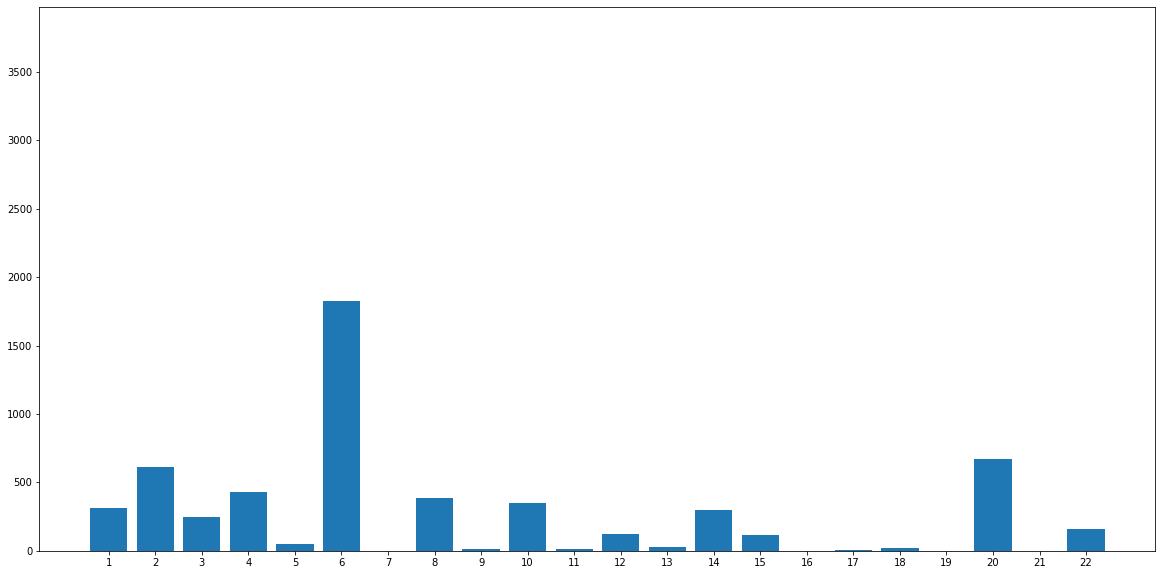

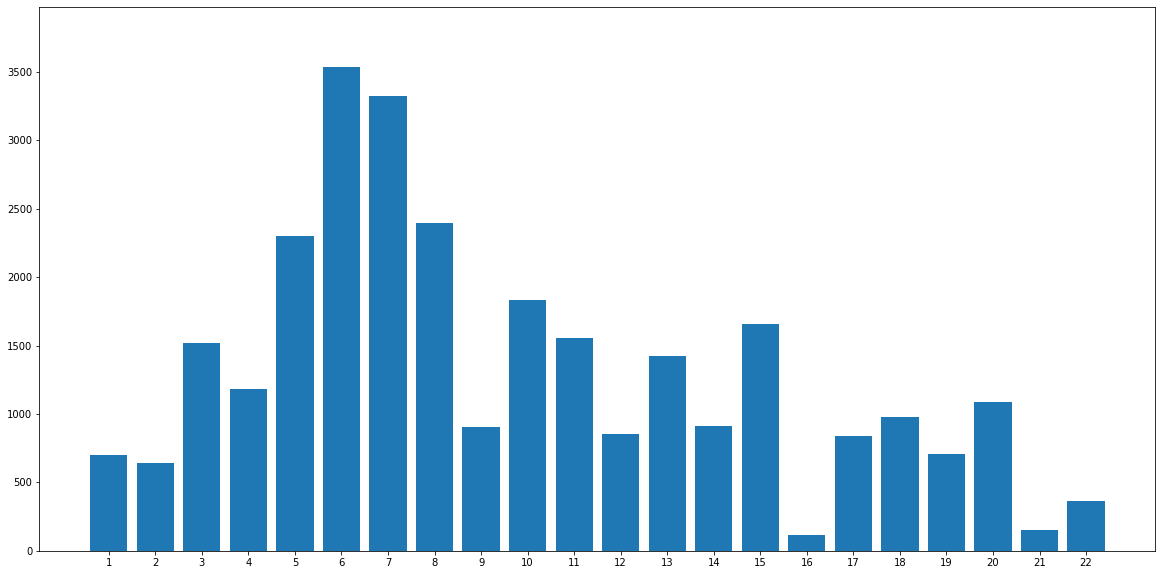

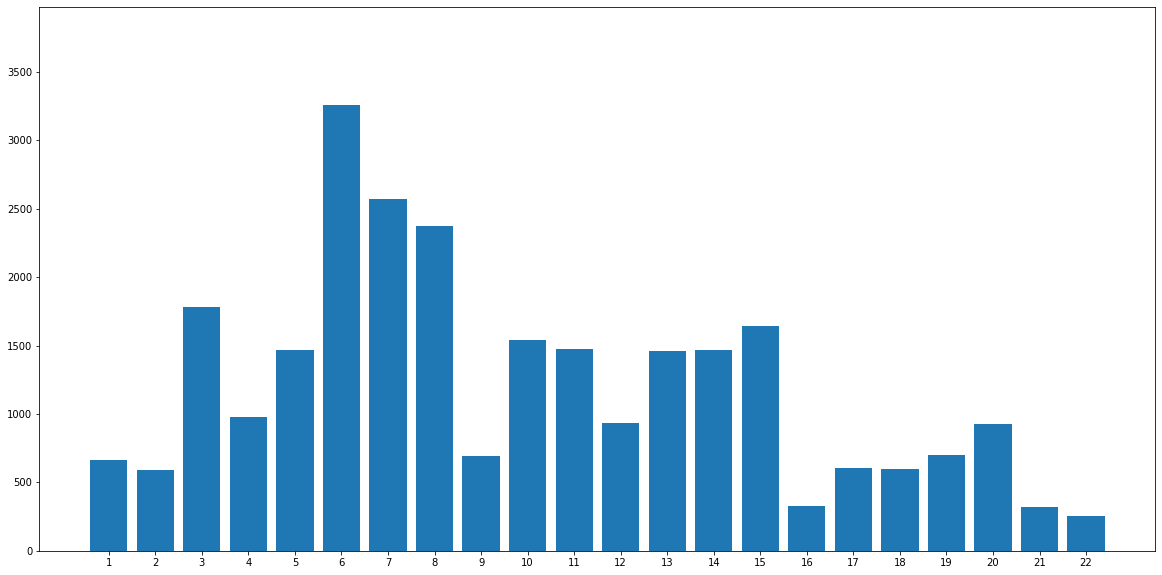

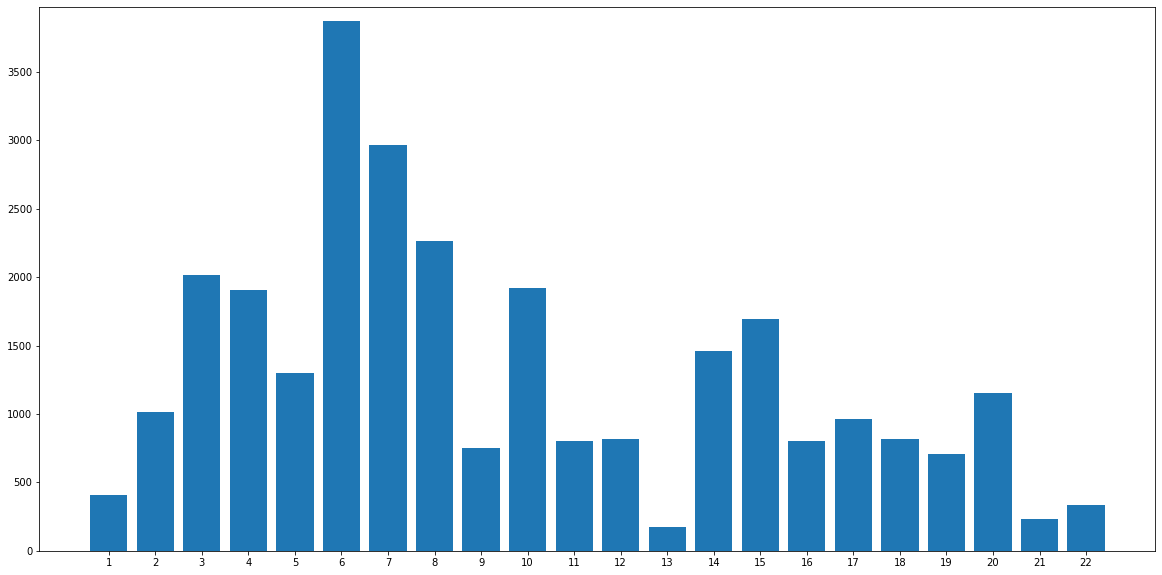

In [33]:
# visualizing areas of every single chromosome of every single tumor
for tumor_areas in tumors_areas:
    visualize_areas_bar(tumor_areas, ylim=[0, np.max(tumors_areas)+100])

In [34]:
# counting relative areas of every chromosome of every tumor
def count_tumors_relative_areas(tumors_areas, tumors_bins):
    tumors_relative_areas = []
    for idx, tumor_areas in enumerate(tumors_areas):
        tumor_relative_areas = count_relative_areas(tumor_areas, tumors_bins[idx])
        tumors_relative_areas.append(tumor_relative_areas)
        
    return tumors_relative_areas

In [35]:
tumors_relative_areas = count_tumors_relative_areas(tumors_areas, tumors_bins)
    
tumors_relative_areas

[[0.047266506217408744,
  0.00820600740131579,
  0.047678490280232265,
  0.0075291370292887025,
  0.00614321083172147,
  0.17557682150160678,
  0.04004598806157713,
  0.005021632513661203,
  0.00405984424778761,
  0.10283597196606419,
  0.004264109589041096,
  0.012989559372666168,
  0.02443298611111111,
  0.008540586865393572,
  0.055369497805948326,
  0.05379711283185841,
  0.08990347290640396,
  0.003986696542893726,
  0.1396547759932375,
  0.21200661379857258,
  0.014380955347871236,
  0.042438364167478086],
 [0.062364693140794236,
  0.126140546875,
  0.06263902044938147,
  0.1120804341004184,
  0.013720696324951643,
  0.5329852468594799,
  0.0,
  0.1324330942622951,
  0.0034587469026548675,
  0.12968074511250463,
  0.004195098111810441,
  0.04528415982076176,
  0.013142803819444444,
  0.1385176245924546,
  0.0551717698683569,
  0.0,
  0.0027278325123152713,
  0.015264199743918055,
  0.0,
  0.530117192704203,
  0.0,
  0.15570827653359298],
 [0.14070224227837946,
  0.131583523848684

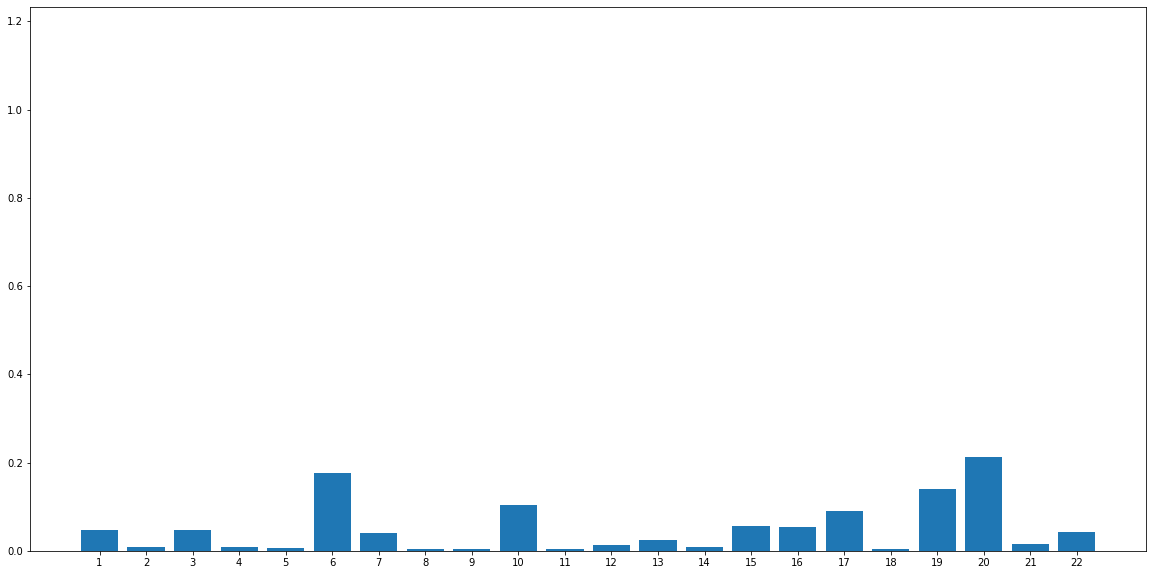

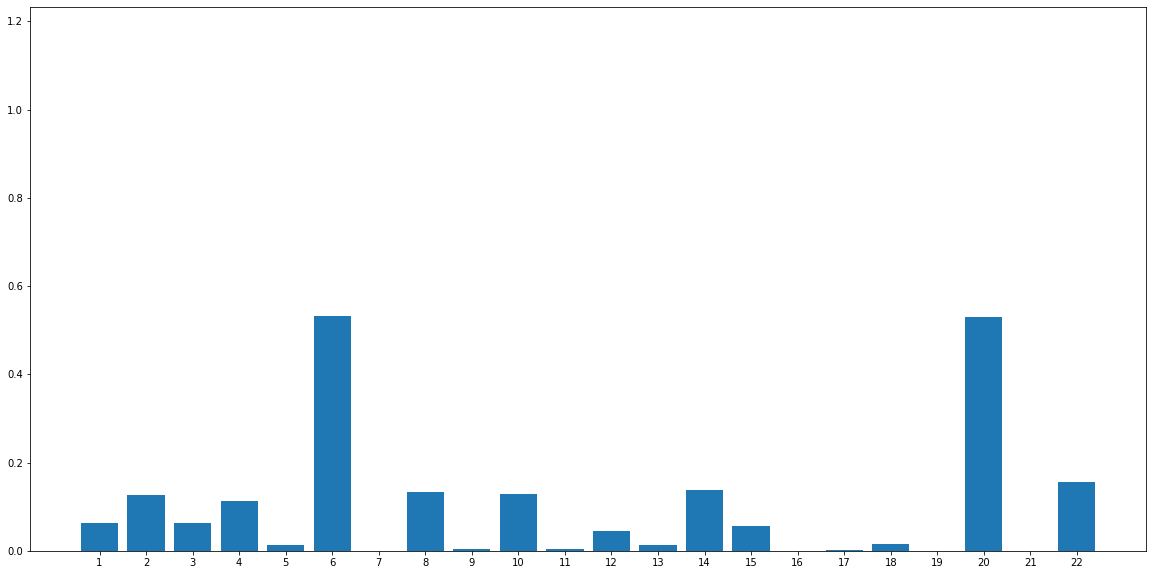

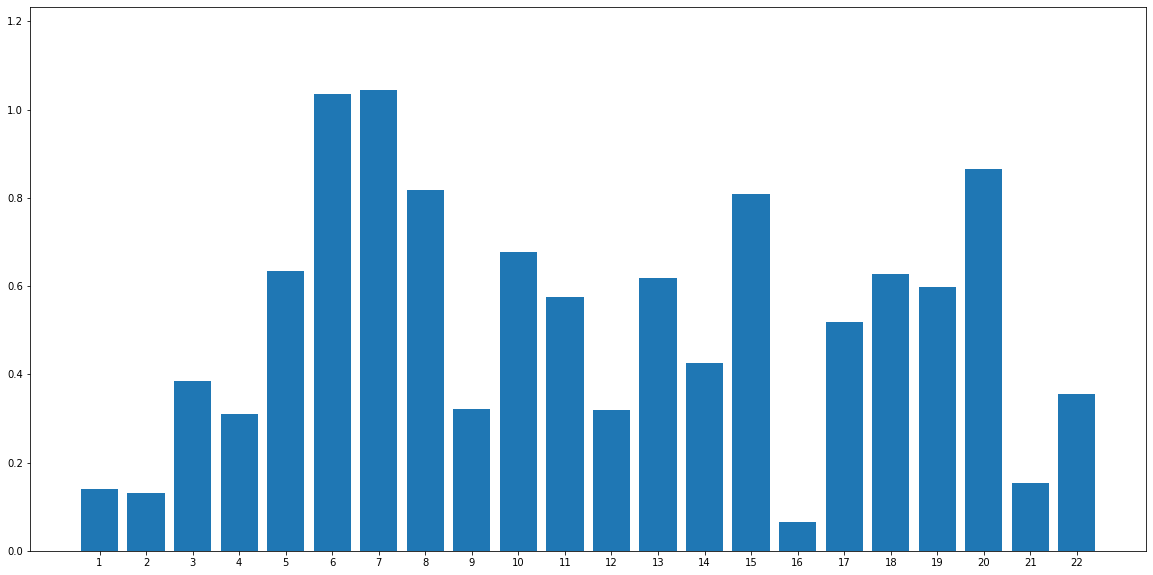

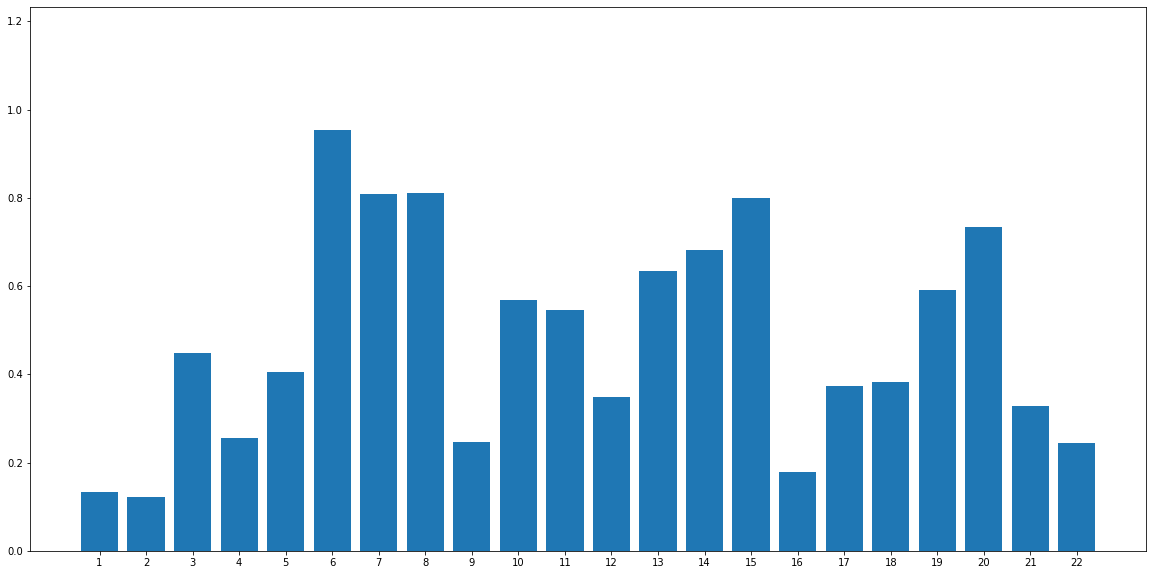

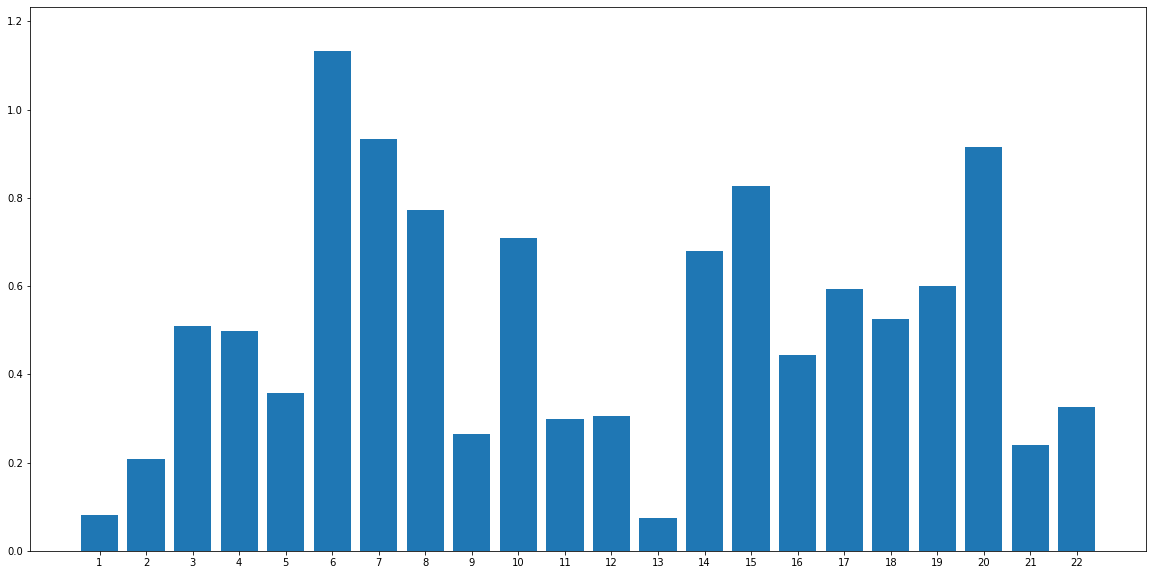

In [117]:
for tumor_relative_areas in tumors_relative_areas:
    visualize_areas_bar(tumor_relative_areas, [0, np.max(tumors_relative_areas) + 0.1])

In [37]:
# count ratio of cnv on all tumors
def count_tumors_cnv_rates(tumors):
    cnv_rates = []
    for tumor in tumors:
        cnv_rate = count_cnv_rate(tumor)
        cnv_rates.append(cnv_rate)
        
    return cnv_rates

In [38]:
cnv_rates = count_tumors_cnv_rates(tumors)

cnv_rates

[0.03786298163550382,
 0.08589494530963099,
 0.4250115967832633,
 0.395492801108438,
 0.41283430794371156]

In [39]:
# visualize and compare cnv of every tumor
def visualize_cnv_rates(cnv_rates):
    tumors_names = ['P', 'Rec4', 'Rec5', 'Rec6', 'Rec7']
    fig, ax = plt.subplots(figsize=(8,8))
    ax.bar(tumors_names, cnv_rates)
    ax.set_ylim([0, 1])

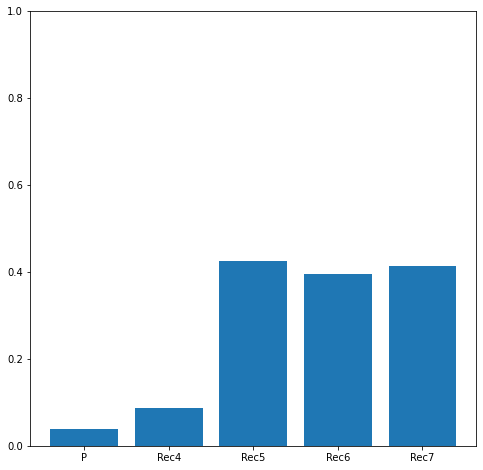

In [40]:
visualize_cnv_rates(cnv_rates)

In [92]:
def count_comparation_matrix(tumors_bins, algorithm):
    matrix = {}
    tumors_names = ['P', 'Rec4', 'Rec5', 'Rec6', 'Rec7']

    for i in range(len(tumors_names)):
        for j in range(i+1, len(tumors_names)):
            bins1 = tumors_bins[i]
            bins2 = tumors_bins[j]

            tumor1_name = tumors_names[i]
            tumor2_name = tumors_names[j]
            
            matrix[(tumor2_name, tumor1_name)] = algorithm(bins1, bins2)
            
    return matrix

In [93]:
jaccard_matrix = count_comparation_matrix(flattened_tumors_bins, jaccard)

jaccard_matrix

{('Rec4', 'P'): 0.8960718515594157,
 ('Rec5', 'P'): 0.40856877505132466,
 ('Rec6', 'P'): 0.4387029132030255,
 ('Rec7', 'P'): 0.4212122706648254,
 ('Rec5', 'Rec4'): 0.46156089520065935,
 ('Rec6', 'Rec4'): 0.49420549117212415,
 ('Rec7', 'Rec4'): 0.4753670306040165,
 ('Rec6', 'Rec5'): 0.9242750538388341,
 ('Rec7', 'Rec5'): 0.9333445152633345,
 ('Rec7', 'Rec6'): 0.9390034653298792}

In [95]:
def comparation_matrix_to_df(algorithm):
    matrix = count_comparation_matrix(flattened_tumors_bins, algorithm)
    series = pd.Series(list(matrix.values()),
                      index=pd.MultiIndex.from_tuples(matrix.keys()))
    df = series.unstack()
    
    return df

In [97]:
jaccard_df = comparation_matrix_to_df(jaccard)

jaccard_df

,P,Rec4,Rec5,Rec6
Rec4,0.896072,NaN,NaN,NaN
Rec5,0.408569,0.461561,NaN,NaN
Rec6,0.438703,0.494205,0.924275,NaN
Rec7,0.421212,0.475367,0.933345,0.939003


Text(0.5, 1.0, 'Jaccard simmilarities')

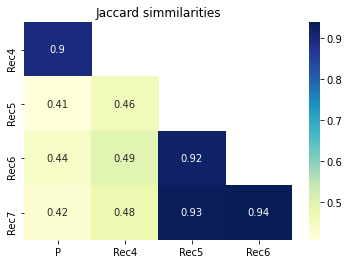

In [106]:
sns.heatmap(jaccard_df, cmap="YlGnBu", annot=True, mask=jaccard_df.isnull())
plt.title('Jaccard simmilarities')

In [78]:
def hamming(tumor1, tumor2):
    tumor1_np = np.array(tumor1)
    tumor2_np = np.array(tumor2)
    
    tumor1_len = len(tumor1_np)
    common_items_len = len(tumor1_np[np.isclose(tumor1_np, tumor2_np)])
    
    return tumor1_len - common_items_len

In [80]:
count_hamming_matrix(flattened_tumors_bins)

{('Rec4', 'P'): 6200,
 ('Rec5', 'P'): 26358,
 ('Rec6', 'P'): 24639,
 ('Rec7', 'P'): 25403,
 ('Rec5', 'Rec4'): 24024,
 ('Rec6', 'Rec4'): 22186,
 ('Rec7', 'Rec4'): 24117,
 ('Rec6', 'Rec5'): 10131,
 ('Rec7', 'Rec5'): 15046,
 ('Rec7', 'Rec6'): 19257}

In [99]:
hamming_df = comparation_matrix_to_df(hamming)

hamming_df

,P,Rec4,Rec5,Rec6
Rec4,6200.0,NaN,NaN,NaN
Rec5,26358.0,24024.0,NaN,NaN
Rec6,24639.0,22186.0,10131.0,NaN
Rec7,25403.0,24117.0,15046.0,19257.0


Text(0.5, 1.0, 'Hamming distances')

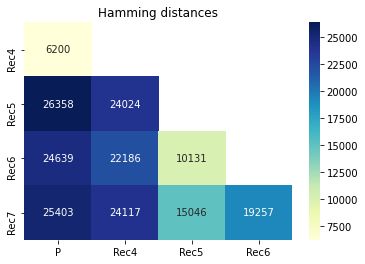

In [105]:
sns.heatmap(hamming_df, cmap="YlGnBu", annot=True, mask=hamming_df.isnull(), fmt='g')
plt.title('Hamming distances')

In [108]:
def l1_distance(tumor1, tumor2):
    l1_dist = 0
    for i in range(len(tumor1)):
        l1_dist += abs(tumor1[i] - tumor2[i])
        
    return l1_dist

In [109]:
def l2_distance(tumor1, tumor2):
    l2_dist = 0
    for i in range(len(tumor1)):
        l2_dist += abs(tumor1[i] - tumor2[i]) ** 2 # |tumor1[i] - tumor2[i]| ^ 2
        
    return l2_dist ** 1. / 2.

In [110]:
l1_df = comparation_matrix_to_df(l1_distance)

l1_df

,P,Rec4,Rec5,Rec6
Rec4,6062.87662,NaN,NaN,NaN
Rec5,28552.72520,25948.75718,NaN,NaN
Rec6,26444.80230,23530.25236,10317.85114,NaN
Rec7,27723.46040,25219.95294,15526.02932,20360.69598


Text(0.5, 1.0, 'L1 distances')

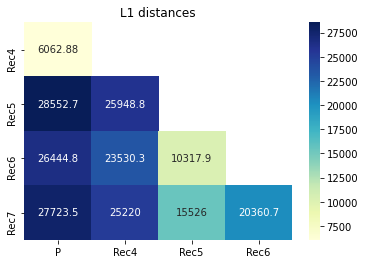

In [113]:
sns.heatmap(l1_df, cmap="YlGnBu", annot=True, mask=l1_df.isnull(), fmt='g')
plt.title('L1 distances')

In [114]:
l2_df = comparation_matrix_to_df(l2_distance)

l2_df

,P,Rec4,Rec5,Rec6
Rec4,3041.120353,NaN,NaN,NaN
Rec5,16646.275410,15084.838584,NaN,NaN
Rec6,15289.097880,13380.279385,5678.067680,NaN
Rec7,16398.155975,13910.936561,8515.280518,11646.754261


Text(0.5, 1.0, 'L2 distances')

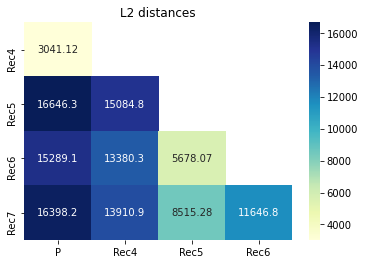

In [115]:
sns.heatmap(l2_df, cmap="YlGnBu", annot=True, mask=l2_df.isnull(), fmt='g')
plt.title('L2 distances')